In [1]:
import pandas as pd
from pandas import Timestamp as tmpstemp
from pandas import Timedelta as tmpdelta
import numpy as np
from math import copysign
import os

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from portfolio import Portfolio
from asset import Asset

os.environ['MY_ENVIRONMENT'] = 'training'
USD = Asset.make_USD()

from strategies import LSTM_Strategy, Rebalancing_Strategy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2024-05-20 22:59:45.411022: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 22:59:45.416867: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 22:59:45.511104: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 22:59:46.620167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/art_usr/source_code/crypto/asset.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old beha

In [2]:
BTC = Asset('BTC')
#BTC.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
ETH = Asset('ETH')
#ETH.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
USDT = Asset('USDT')
#USDT.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2021-01-01'), date_to = tmpstemp('2024-03-31'))

In [3]:
naive_LSTM = LSTM_Strategy(model_input_length = 15)
date_from = tmpstemp('2022-01-01')
x_train, y_train, train_idx, x_val, y_val, val_idx = naive_LSTM.train_val_split_scale(BTC.history.loc[date_from:])

rebalncer = Rebalancing_Strategy(target_allocations = {'USD':0.4, 'BTC':0.4, 'ETH':0.2})

In [4]:
'''
hidden_size = 50
dropout = 0.2
learning_rate = 0.0005

input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]), name = 'input')

LSTM1 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM1' )(input_layer)
LSTM1 = Dropout(dropout)(LSTM1)

LSTM2 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM2' )(LSTM1)
LSTM2 = Dropout(dropout)(LSTM2)

LSTM3 = LSTM(units = 50, activation='tanh', name = 'LSTM3' )(LSTM2)
LSTM3 = Dropout(dropout)(LSTM3)

hidden1 = Dense(hidden_size, activation='relu', name='hidden_layer1')(LSTM3)
hidden1 = Dropout(dropout)(hidden1)


# Create output layer
out = Dense(1, activation='linear', name = 'Regression_layer')(LSTM3)
latest_model = Model(inputs=[input_layer], outputs=out)

latest_model.compile(optimizer=Adam(learning_rate),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.losses.MeanSquaredError()])

#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

latest_model.fit([x_train], y_train, 
          validation_data=([x_val], y_val),
          epochs=20, batch_size=64,
          callbacks=[early_stopping])

p = os.path.abspath('.')
model_dir = os.path.join(p, 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_path = os.path.join(model_dir, 'naive_LSTM.keras')
latest_model.save(model_path)
'''

'\nhidden_size = 50\ndropout = 0.2\nlearning_rate = 0.0005\n\ninput_layer = Input(shape=(x_train.shape[1], x_train.shape[2]), name = \'input\')\n\nLSTM1 = LSTM(units = 50, activation=\'tanh\', return_sequences=True, name = \'LSTM1\' )(input_layer)\nLSTM1 = Dropout(dropout)(LSTM1)\n\nLSTM2 = LSTM(units = 50, activation=\'tanh\', return_sequences=True, name = \'LSTM2\' )(LSTM1)\nLSTM2 = Dropout(dropout)(LSTM2)\n\nLSTM3 = LSTM(units = 50, activation=\'tanh\', name = \'LSTM3\' )(LSTM2)\nLSTM3 = Dropout(dropout)(LSTM3)\n\nhidden1 = Dense(hidden_size, activation=\'relu\', name=\'hidden_layer1\')(LSTM3)\nhidden1 = Dropout(dropout)(hidden1)\n\n\n# Create output layer\nout = Dense(1, activation=\'linear\', name = \'Regression_layer\')(LSTM3)\nlatest_model = Model(inputs=[input_layer], outputs=out)\n\nlatest_model.compile(optimizer=Adam(learning_rate),\n              loss=keras.losses.MeanSquaredError(),\n              metrics=[keras.losses.MeanSquaredError()])\n\n#Set up early stopping monitor\

In [5]:
#Load model
#naive_LSTM.model = keras.models.load_model(
#    model_path, custom_objects=None, compile=True)

In [6]:
assets_in_portfolio = {'USD': 0.2* BTC.price_on_date(date_from - tmpdelta(days=1)), 'BTC':0.4, 'ETH': 8}
my_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         assets = assets_in_portfolio)

buy_n_hold_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         assets = assets_in_portfolio)

rebal_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         assets = assets_in_portfolio)

In [7]:
pred_df = pd.DataFrame(data=[],
                        columns = ['Predicted price'],
                        index = pd.DatetimeIndex([], name='date_time'))

#Find record in BTC history that is closest to the origin date of the portfolio
first_index = BTC.history.index.get_indexer([my_portfolio.orig_date], method='nearest')[0] + 1
first_date = BTC.history.index[first_index]

#alloc_exp = []
alloc_rebal = []
alloc_bnh = []
for today in BTC.history.index[first_index:-2]:
    '''
    tmr = today + tmpdelta(days=1)
    alloc_exp.append(my_portfolio.get_hist_positions(today)['allocation'].loc['BTC'])
    today_data = BTC.history['close'].\
                        loc[today-tmpdelta(days=(naive_LSTM.input_span-1)):today]
    new_pred = naive_LSTM.predict_one(today_data)
    pred_df = pd.concat([pred_df, new_pred], axis = 0)
    suggestion = naive_LSTM.make_suggestion(on_date = today, portfolio = rebal_portfolio)
    my_portfolio.execute_suggestions(sggst_df = suggestion, exec_date = today)
    '''
    alloc_rebal.append(rebal_portfolio.get_hist_positions(today)['allocation'].loc['BTC'])
    rebal_suggest = rebalncer.make_suggestion(on_date = today, portfolio = rebal_portfolio)
    rebal_portfolio.execute_suggestions(sggst_df = rebal_suggest, exec_date = today)

    alloc_bnh.append(buy_n_hold_portfolio.get_hist_positions(today)['allocation'].loc['BTC'])

#my_portfolio.update_value(up_to=pred_df.index[-1])
buy_n_hold_portfolio.update_value(up_to=BTC.history.index[-1])
rebal_portfolio.update_value(up_to=BTC.history.index[-1])

-----START OF EXECUTION ---------
Suggested changes
       position_size position_value allocation  target  on_date_price  \
ticker                                                                  
USD         9242.248       9242.248   0.158092     0.4           1.00   
BTC              0.4      19093.372   0.326598     0.4       47733.43   
ETH                8       30125.76    0.51531     0.2        3765.72   

       change_in_USD_value change_in_size                    note  
ticker                                                             
USD              14142.304      14142.304  2021-12-31 rebalancing  
BTC                4291.18       0.089899  2021-12-31 rebalancing  
ETH             -18433.484      -4.895076  2021-12-31 rebalancing  
Current portfolio for 2021-12-31 23:59:00
       position_size position_value allocation
ticker                                        
BTC              0.4      19093.372   0.326598
ETH                8       30125.76    0.51531
USD         

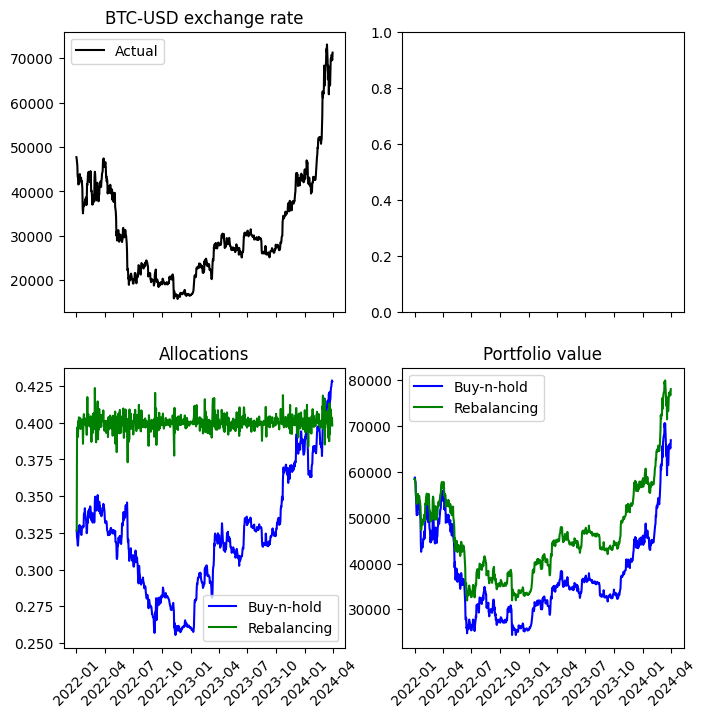

In [8]:
# Plot the results
fig, ax = plt.subplots(2, 2, sharex = True)
fig.set_figheight(8)
fig.set_figwidth(8)
actual_df = BTC.history.loc[first_date:]
ax[0,0].plot(actual_df.index, actual_df['close'], color = 'black', label = 'Actual')
# ax[0,0].plot(pred_df.index, pred_df['Predicted price'], color = 'magenta', label = 'Predicted')
ax[0,0].legend()
ax[0,0].set_title('BTC-USD exchange rate')
for tick in ax[0,0].get_xticklabels():
        tick.set_rotation(45)
'''
ax[0,1].plot(my_portfolio.value.index, (my_portfolio.value['value'] - buy_n_hold_portfolio.value['value'])/buy_n_hold_portfolio.value['value'], color = 'blue', label = 'Comp to buy-and-hold')
ax[0,1].plot(my_portfolio.value.index, (my_portfolio.value['value'] - rebal_portfolio.value['value'])/rebal_portfolio.value['value'], color = 'green', label = 'Comp to rebalancing')
ax[0,1].legend()
ax[0,1].set_title('Ratio w other portfolio')
for tick in ax[0,1].get_xticklabels():
        tick.set_rotation(45)
'''

ax[1,0].plot(buy_n_hold_portfolio.value.index[1:-1], alloc_bnh, color = 'blue', label = 'Buy-n-hold')
#ax[1,0].plot(my_portfolio.value.index[:-1], alloc_exp, color = 'red', label = 'Experiment')
ax[1,0].plot(rebal_portfolio.value.index[1:-1], alloc_rebal, color = 'green', label = 'Rebalancing')
ax[1,0].legend()
ax[1,0].set_title('Allocations')
for tick in ax[1,0].get_xticklabels():
        tick.set_rotation(45)

#ax[1,1].plot(my_portfolio.value.index, my_portfolio.value['value'], color = 'red', label = 'Experiment')
ax[1,1].plot(buy_n_hold_portfolio.value.index, buy_n_hold_portfolio.value['value'], color = 'blue', label = 'Buy-n-hold')
ax[1,1].plot(rebal_portfolio.value.index, rebal_portfolio.value['value'], color = 'green', label = 'Rebalancing')
ax[1,1].legend()
ax[1,1].set_title('Portfolio value')
for tick in ax[1,1].get_xticklabels():
        tick.set_rotation(45)

In [9]:
def cross_val_percentages(num_blocks=5, split_ratio=0.8):
    '''
    Creates cross validation block percentiles for both the train and validation sets
    based off the number of blocks and split ratios identified.
    '''
    # creating percentile boundaries for train and validation blocks
    val_area = 1- (1-split_ratio) * 1/num_blocks
    train_block = (1-split_ratio) * 1/num_blocks
    train_blocks_boundaries = [(val_area*i/num_blocks, val_area*(i+1)/num_blocks) for i in range(num_blocks)]
    val_blocks_boundaries = [(val_block[1], val_block[1] + train_block ) for val_block in train_blocks_boundaries]
    print("Train blocks: ", train_blocks_boundaries)
    print("Validation blocks: ", val_blocks_boundaries)
    return train_blocks_boundaries, val_blocks_boundaries

In [10]:
cross_val_percentages(5, 0.7)

Train blocks:  [(0.0, 0.188), (0.188, 0.376), (0.376, 0.564), (0.564, 0.752), (0.752, 0.9399999999999998)]
Validation blocks:  [(0.188, 0.248), (0.376, 0.436), (0.564, 0.624), (0.752, 0.812), (0.9399999999999998, 0.9999999999999999)]


([(0.0, 0.188),
  (0.188, 0.376),
  (0.376, 0.564),
  (0.564, 0.752),
  (0.752, 0.9399999999999998)],
 [(0.188, 0.248),
  (0.376, 0.436),
  (0.564, 0.624),
  (0.752, 0.812),
  (0.9399999999999998, 0.9999999999999999)])

In [11]:
def create_validation_blocks(df, split_feature, blocks=5, split=0.8):
    '''
    Function that orders and ranks a df based on a specified feature, 
    and then splits it into equal train and validation blocks based off
    the specified number of blocks and split percent.
    Returns a list of tuples for the train and validation datasets.
    '''
    # defining the window feature for splitting
    window_spec = W.partitionBy().orderBy(split_feature)

    # creating a rank column for ordered df
    ranked_df = df.withColumn("rank", f.percent_rank().over(window_spec))
    
    # creating cross validation percentiles
    train_blocks, val_blocks = cross_val_percentages(blocks, split)

    # Assemble tuples of train and val datasets for cross-validations
    val_train_sets = []
    for train_b, val_b in zip(train_blocks, val_blocks):
        val_train_sets.append((
                                ranked_df.where(f"rank <= {train_b[1]} and rank >= {train_b[0]}").drop('rank')
                                , ranked_df.where(f"rank > {val_b[0]} and rank <= {val_b[1]}").drop('rank')
                                ))
    return val_train_sets